In [1]:
import cv2
import json
import urllib
import copy
import numpy as np
from pathlib import Path
import PIL.Image as Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from IPython.display import Image
PATH_ANOT = 'data/ann/'
PATH_IMG = 'data/img/'

plt.rcParams["figure.figsize"] = (10,10)

## Data


In [2]:
# check json
f = 'data/ann/11752905643_a17ce5b925_c.jpg.json'
with Path(f).open() as json_file:
    data = json.load(json_file) 
data

{'description': '',
 'tags': [],
 'size': {'height': 541, 'width': 800},
 'objects': [{'id': 700799253,
   'classId': 2908317,
   'description': '',
   'geometryType': 'rectangle',
   'labelerLogin': 'beifa',
   'createdAt': '2021-04-27T17:22:24.515Z',
   'updatedAt': '2021-04-27T17:23:01.398Z',
   'tags': [],
   'classTitle': 'parrot',
   'points': {'exterior': [[210, 133], [436, 416]], 'interior': []}}]}

In [3]:
tmp = []
for f, img in zip(sorted(Path(PATH_ANOT).glob('*.*')), sorted(Path(PATH_IMG).glob('*.*'))):
    with Path(f).open() as json_file:
        # loads json
        data = json.load(json_file)
        # add array img to dict save to use after
        data['image'] = cv2.cvtColor( cv2.imread(str(img)), cv2.COLOR_BGR2RGB) 
        tmp.append(data)

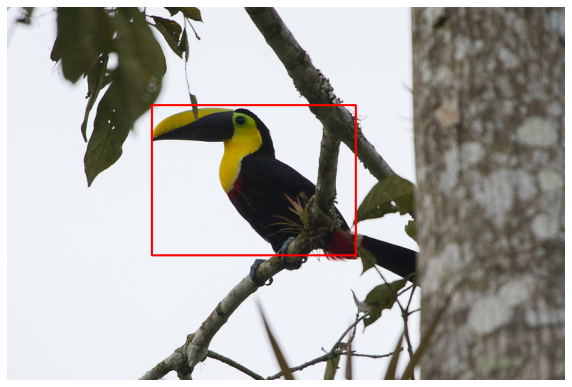

In [4]:
example_img = copy.deepcopy(tmp[1]['image'])

p1, p2 = tmp[1]['objects'][0]['points']['exterior']
x1, y1 = p1
x2, y2 = p2

exp_box = cv2.rectangle(
    example_img,(int(x1), int(y1)),(int(x2), int(y2)),
    color = (255, 0, 0),
    thickness = 2
    )

plt.imshow(exp_box)
plt.axis('off');

## Split data

In [5]:
tr, vl = train_test_split(tmp, test_size =.2, random_state=13)
len(tr), len(vl)

(61, 16)

## Make data for Yolo

In [6]:
def make_data(list_jsn: list, mark: str)->None:
    """
    list_jsn: list dict
    mark: train or val change name dir
    we make data to yolo format:
    |_data
        |_images
            |-train
            |-val
        |-label
            |-train
            |-val
    
    *317 parrot
    *318 toucan
    """
    # labels id to save
    tmp_ids = {'2908317': 0, '2908318': 1}

    img_path = Path(f'parrot_train/images/{mark}')
    img_path.mkdir(parents=True, exist_ok = True)

    lb_path = Path(f'parrot_train/labels/{mark}')
    lb_path.mkdir(parents=True, exist_ok = True)

    for i in range(len(list_jsn)):
        data = list_jsn[i]
        name_ids = data['objects'][0]['id']
        img = Image.fromarray(data['image'])  
        label_ids = tmp_ids[str(data['objects'][0]['classId'])]
        # rename and save img
        img.save(img_path / f'{name_ids}.jpeg')
        # point in pixels need normolize to yolo format
        box = data['objects'][0]['points']['exterior']
        bbox = np.array(box).ravel()
        h, w = data['size']['height'], data['size']['width']
        p1, p2 = tmp[0]['objects'][0]['points']['exterior']
        x1, y1 = p1
        x2, y2 = p2
        # https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        b_width = bbox[2,]
        b_height = bbox[3,]
        x_max = bbox[0,] + b_width
        y_max = bbox[1,] + b_height
        x_center= ((x_max + bbox[0,]) / 2)  / w
        y_center = ((y_max + bbox[1,]) / 2)  / h
        w1 = bbox[2,] / w
        h1 = bbox[3,] / h
        # save format Each row is class x_center y_center width height format
        with (lb_path / f'{name_ids}.txt').open(mode = 'w') as lb:
            lb.write(f"{label_ids} {x_center} {y_center} {w1} {h1}\n")

In [125]:
# make data to rain
mark = 'train'
make_data(tr, mark)
mark = 'val'
make_data(vl, mark)

In [7]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 6127, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 6127 (delta 83), reused 101 (delta 64), pack-reused 5980
Receiving objects: 100% (6127/6127), 8.70 MiB | 10.40 MiB/s, done.
Resolving deltas: 100% (4175/4175), done.


## Train model

last we need make yaml

config_yolo/data_config.yaml
```
colors:
- [151, 126, 226]
- [85, 216, 24]
# set label
names: [parrot, toucan]
# num label
nc: 2
# path to label
train: ../parrot_train/images/train
val: ../parrot_train/images/val
```
config_yolo/yolov5m.yaml
```
change one param num class
nc: 2  # number of classes
```

In [ ]:
%run train.py --img 640 --batch 9 --epochs 150\
                 --data ../config_yolo/data_config.yaml\
                 --cfg ../config_yolo/yolov5m.yaml\
                 --weights yolov5m.pt\
                 --name ../model_yolo/yolov5m_parrot\
                 --cache

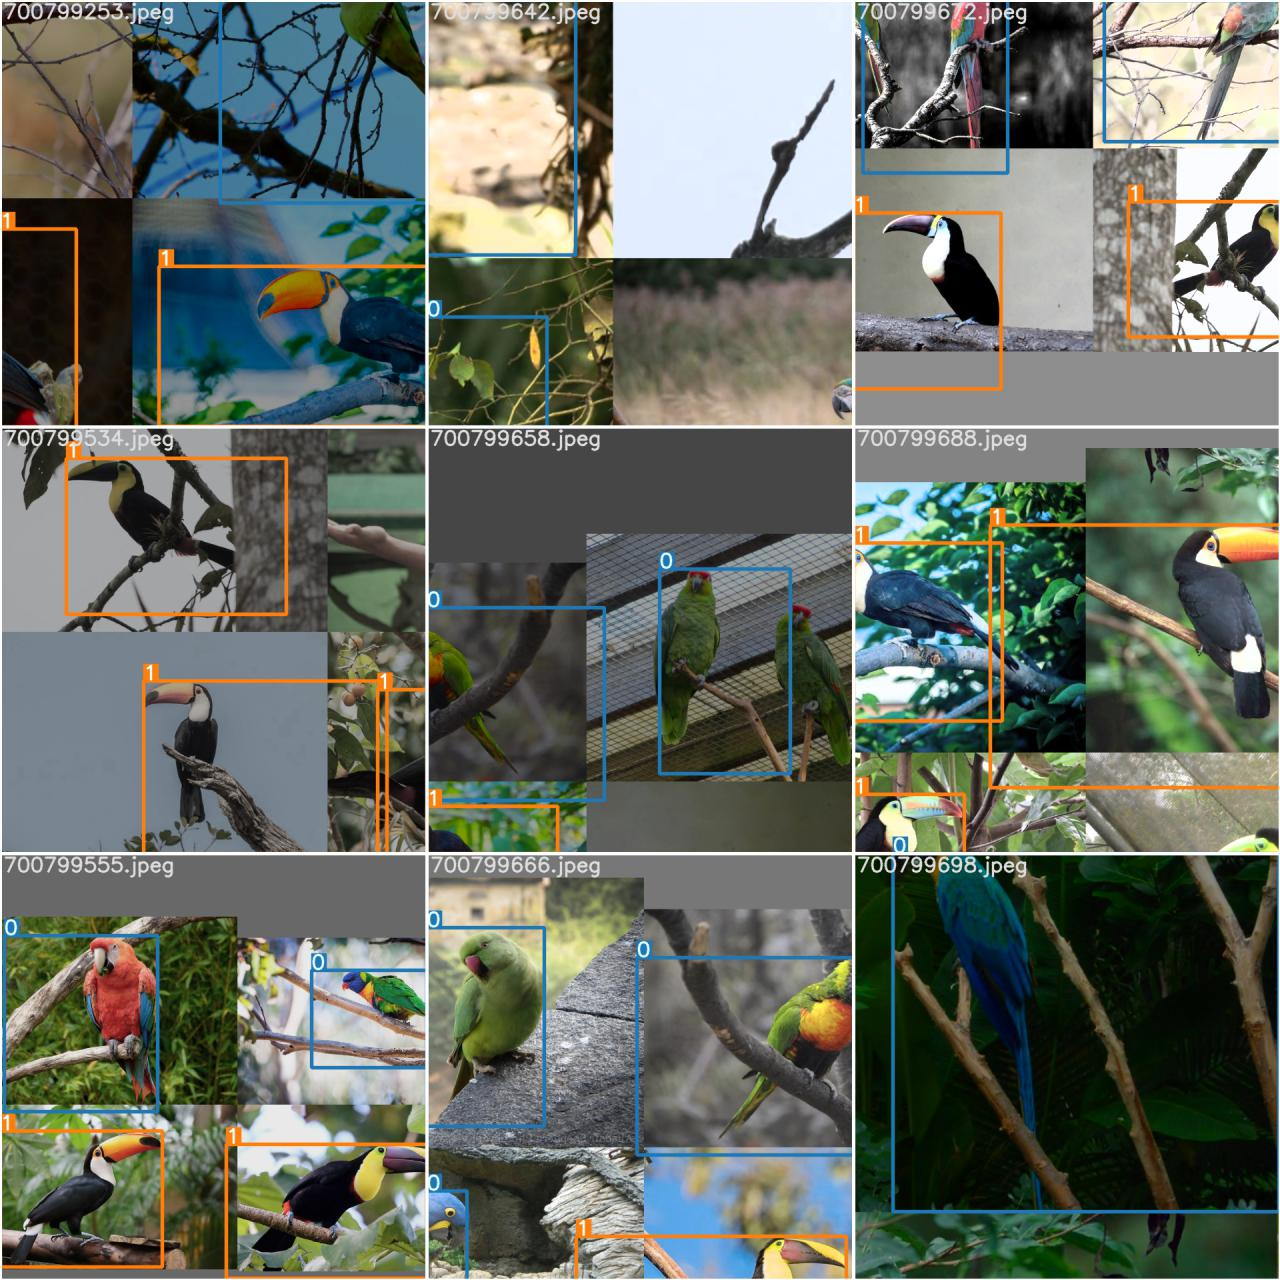

In [19]:
# result train model
Image(filename='model_yolo/yolov5m_parrot8/train_batch0.jpg', width=800) 

## Validate

In [ ]:
%run yolov5/detect.py --weights model_yolo/yolov5m_parrot8/weights/best.pt\
                      --img 640\
                      --conf 0.4\
                      --source parrot_train/images/val

In [26]:
tmp = []
# after each pred changed exp{num} change
for f in Path('runs/detect/').glob(f'exp/*.*'):
    im = cv2.imread(str(f))
    out = cv2.resize(im, (320, 320), interpolation = cv2.INTER_AREA)
    tmp.append(out)    

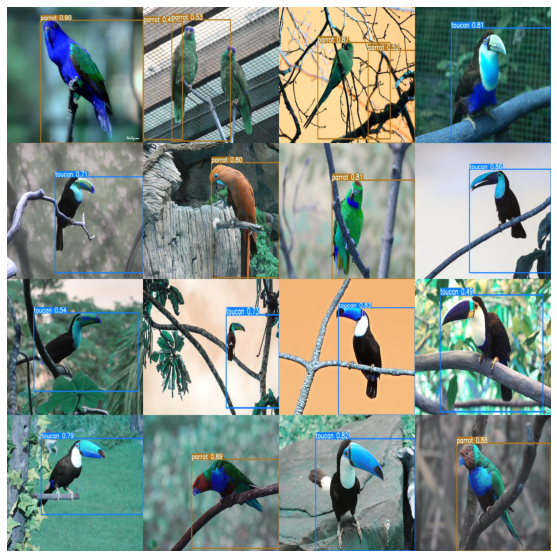

In [27]:
plt.imshow(np.concatenate(np.array(tmp).reshape(4, 320*4,320,3), axis= 1));
plt.axis('off');

## Test

In [ ]:
%run yolov5/detect.py --weights model_yolo/yolov5m_parrot8/weights/best.pt\
                      --img 640\
                      --conf 0.5\
                      --source test_img_upload/

In [28]:
tmp = []
# after each pred changed exp{num} change
for f in Path('runs/detect/').glob(f'exp5/*.*'):
    im = cv2.imread(str(f))
    out = cv2.resize(im, (512, 512), interpolation = cv2.INTER_AREA)
    tmp.append(out)  

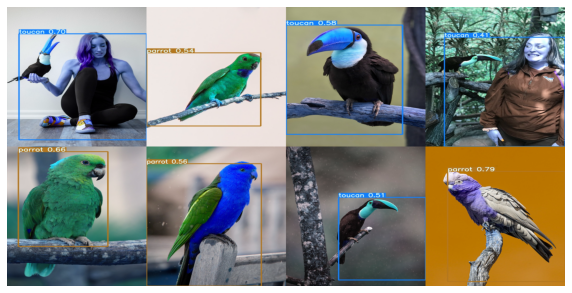

In [31]:
plt.imshow(np.concatenate(np.array(tmp).reshape(4, 512*2,512,3), axis= 1));
plt.axis('off');

We can see, the model was to determine where the parrot is and where toucan.